# Binary Classification with CNNs: Chest X-Ray Images (Pneumonia)

## Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import datetime

notebook_start_time = datetime.datetime.now()

2025-04-26 14:21:54.245104: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-26 14:21:54.255381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745691714.269015   89907 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745691714.272824   89907 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745691714.283245   89907 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
test_dir = "data/test"
train_dir = "data/train"
validation_dir = "data/val"

height, width, channels = 150, 150, 1

batch_size = 32

# While working, I discovered that the tf.keras.preprocessing.image.ImageDataGenerator class is deprecated
# using this new API instead

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(height, width),
    batch_size=batch_size,
    label_mode='int',
    color_mode='grayscale',
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(height, width),
    batch_size=batch_size,
    label_mode='int',
    color_mode='grayscale',
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(height, width),
    batch_size=batch_size,
    label_mode='int',
    color_mode='grayscale',
)

# because the outputs are batched, we have to concatenate all the batches
y_true = np.concatenate([y for x, y in test_ds], axis=0)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


2025-04-26 14:21:55.646786: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-04-26 14:21:56.002180: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
def summary_graphics(history, model):
    y_pred = np.round(model.predict(test_ds))
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(16, 5)
    ax = ax.flatten()

    # true/false positive/negative rates (better than accuracy for imbalanced data!)
    ax[0].plot(history.history['tp'], label = 'True Positives', color='g')
    #ax[0].plot(history.history['fp'], label = 'False Positives')
    ax[0].plot(history.history['tn'], label = 'True Negatives', color='r')
    #ax[0].plot(history.history['fn'], label = 'False Negatives', color='orange')
    ax[0].grid(True)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Metric Value')
    ax[0].legend(loc='right')
    ax[0].set_title('True Positive and True Negative Rates')

    # loss
    ax[1].plot(history.history['loss'], label='Loss')
    ax[1].plot(history.history['val_loss'], label = 'Val Loss')
    ax[1].grid(True)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend(loc='upper right')
    ax[1].set_title('Loss')

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[2])
    ax[2].set_xlabel('Predicted')
    ax[2].set_ylabel('True')
    ax[2].xaxis.set_ticklabels([f'Normal ({(cm[0][0] + cm[1][0])/len(y_pred):.3f})', f'Pneumonia ({(cm[0][1] + cm[1][1])/len(y_pred):.3f})'])
    ax[2].yaxis.set_ticklabels([f'Normal ({(cm[0][0] + cm[0][1])/len(y_pred):.3f})', f'Pneumonia ({(cm[1][0] + cm[1][1])/len(y_pred):.3f})'])
    ax[2].set_title('Confusion Matrix')

    plt.show()

def get_class_training_weights(train_ds, normalize = True):
    labels, counts = np.unique(np.concatenate([y for x, y in train_ds], axis=0), return_counts=True)
    total = sum(counts)

    weights = [total/(2*count) for count in counts]
    max_weight = np.max(weights)

    if normalize:
        return {l : weights[i]/max_weight for i, l in enumerate(labels)}

    return {l : weights[i] for i, l in enumerate(labels)}


In [4]:
class_weight = get_class_training_weights(train_ds=train_ds)

print(f"Weight for normal class: {class_weight[0]:1.3f}")
print(f"Weight for pneumonia class: {class_weight[1]:1.3f}")

Weight for normal class: 1.000
Weight for pneumonia class: 0.346


2025-04-26 14:21:58.263327: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Training

In [ ]:
epochs = 10
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((height, width, channels), name="input"),

    tf.keras.layers.RandomFlip("horizontal", name="0.1rflip"),
    tf.keras.layers.RandomRotation(0.2, name="0.2rrot"),
    tf.keras.layers.RandomTranslation(0.2, 0.2, name="0.3rtran"),
    tf.keras.layers.RandomZoom(0.2, name="0.4rzoom"),

    tf.keras.layers.Rescaling(1./255, name="rescale"),

    # initial layers of Xception are similar to VGG16
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="1.1conv"),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="1.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="1.3pool"),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', name="2.1conv"),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', name="2.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="2.3pool"),

    # the rest of the convolutional layers in Xception are blocks of 2-3 depthwise separable layers, followed by a pooling layer
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.1conv"),
    tf.keras.layers.BatchNormalization(name="3.2batchnorm"),
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.3conv"),
    tf.keras.layers.MaxPooling2D((2,2), name='3.4pool'),

    tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name="4.1conv"),
    tf.keras.layers.BatchNormalization(name="4.2batchnorm"),
    tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name='4.3conv'),
    tf.keras.layers.MaxPooling2D((2,2), name="4.6pool"),

    # all the CNN models end with dense layers, probably to help the model "interpret" what the convolutional layers see
    tf.keras.layers.Flatten(name="5.1flatten"),

    tf.keras.layers.Dense(1024, activation='relu', name="5.2dense"),
    # the above dense layer has 42 million of the 43 million trainable parameters!!!
    # add in a dropout layer with a high rate to prevent overfitting
    tf.keras.layers.Dropout(0.7, name="5.3dropout"),

    tf.keras.layers.Dense(512, activation='relu', name="5.4dense"),
    tf.keras.layers.Dropout(0.5, name="5.5dropout"),

    # 1 output neuron with sigmoid is equivalent to 2 output neurons with softmax, but trains faster:
    # https://stats.stackexchange.com/questions/207049/neural-network-for-binary-classification-use-1-or-2-output-neurons
    #tf.keras.layers.Dense(2, activation="softmax", name="output")
    tf.keras.layers.Dense(1, activation="sigmoid", name="output")
], name="Model_1")

metrics = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics,
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

model_1.summary()

Model: "Model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ 0.1rflip (RandomFlip)           │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 0.2rrot (RandomRotation)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 0.3rtran (RandomTranslation)    │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 0.4rzoom (RandomZoom)           │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescale (Rescaling)             │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.1conv (Conv2D)                │ (None, 150, 150, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.2conv (Conv2D)                │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.3pool (MaxPooling2D)          │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.1conv (Conv2D)                │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.2conv (Conv2D)                │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.3pool (MaxPooling2D)          │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.1conv (SeparableConv2D)       │ (None, 37, 37, 256)    │        34,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.2batchnorm                    │ (None, 37, 37, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.3conv (SeparableConv2D)       │ (None, 37, 37, 256)    │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.4pool (MaxPooling2D)          │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.1conv (SeparableConv2D)       │ (None, 18, 18, 512)    │       133,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.2batchnorm                    │ (None, 18, 18, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.3conv (SeparableConv2D)       │ (None, 18, 18, 512)    │       267,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.6pool (MaxPooling2D)          │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.1flatten (Flatten)            │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.2dense (Dense)                │ (None, 1024)           │    42,468,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.3dropout (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.4dense (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 5.5dropout (Dropout)            │ (None, 512)            │             

 Total params: 43,759,169 (166.93 MB)

 Trainable params: 43,757,633 (166.92 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [17]:
history = model_1.fit(
    train_ds,
    validation_data=validation_ds,
    batch_size=batch_size,
    epochs=epochs,
    class_weight=class_weight,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 856s 5s/step - accuracy: 0.3309 - loss: 0.3492 - precision: 0.7267 - recall: 0.1039 - tn: 651.7744 - tp: 323.8903 - val_accuracy: 0.5000 - val_loss: 0.8516 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 868s 5s/step - accuracy: 0.7913 - loss: 0.2220 - precision: 0.9362 - recall: 0.7696 - tn: 591.5366 - tp: 1515.6890 - val_accuracy: 0.5000 - val_loss: 1.2453 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 867s 5s/step - accuracy: 0.8274 - loss: 0.1910 - precision: 0.9545 - recall: 0.8035 - tn: 610.8293 - tp: 1588.3353 - val_accuracy: 0.5000 - val_loss: 2.1535 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 870s 5s/step - accuracy: 0.8431 - loss: 0.1751 - precision: 0.9574 - recall: 0.8230 - tn: 617.6768 - tp: 1615.4512 - val_

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step


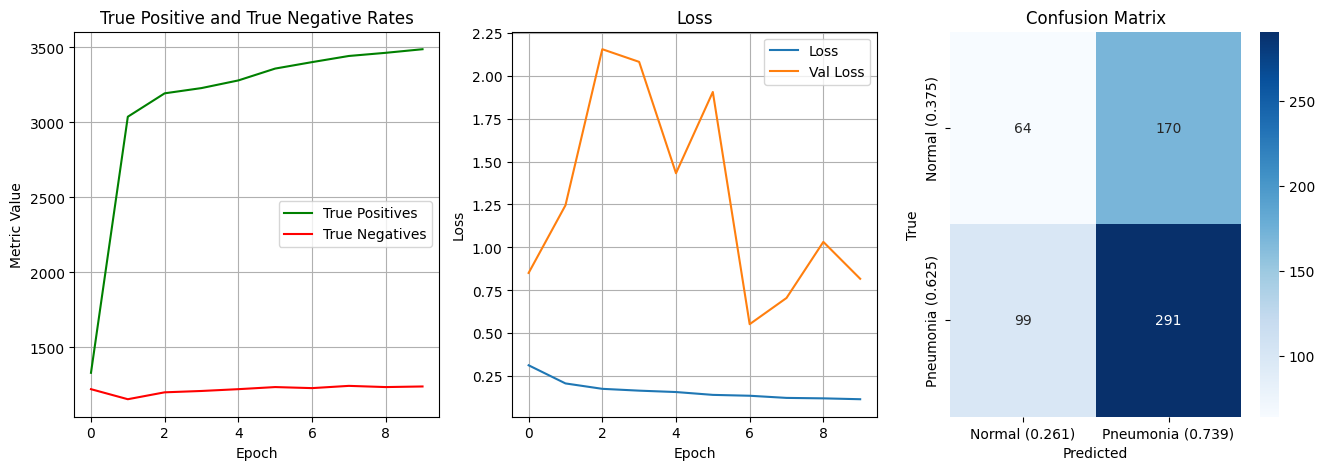

In [18]:
summary_graphics(history, model_1)

In [19]:
# add in several additional layers in the separable convolution blocks
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((height, width, channels), name="input"),

    tf.keras.layers.RandomFlip("horizontal", name="0.1rflip"),
    tf.keras.layers.RandomRotation(0.2, name="0.2rrot"),
    tf.keras.layers.RandomTranslation(0.2, 0.2, name="0.3rtran"),
    tf.keras.layers.RandomZoom(0.2, name="0.4rzoom"),

    tf.keras.layers.Rescaling(1./255, name="rescale"),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="1.1conv"),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="1.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="1.3pool"),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', name="2.1conv"),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', name="2.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="2.3pool"),

    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.1conv"),
    tf.keras.layers.BatchNormalization(name="3.2batchnorm"),
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.3conv"),
    tf.keras.layers.BatchNormalization(name="3.4batchnorm"),
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.5conv"),
    tf.keras.layers.MaxPooling2D((2,2), name='3.6pool'),

    tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name="4.1conv"),
    tf.keras.layers.BatchNormalization(name="4.2batchnorm"),
    tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name='4.3conv'),
    tf.keras.layers.BatchNormalization(name="4.4batchnorm"),
    tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name='4.5conv'),
    tf.keras.layers.MaxPooling2D((2,2), name="4.6pool"),

    tf.keras.layers.Flatten(name="5.1flatten"),
    tf.keras.layers.Dense(1024, activation='relu', name="5.2dense"),
    tf.keras.layers.Dropout(0.7, name="5.3dropout"),
    tf.keras.layers.Dense(512, activation='relu', name="5.4dense"),
    tf.keras.layers.Dropout(0.5, name="5.5dropout"),

    tf.keras.layers.Dense(1, activation="sigmoid", name="output")
], name="Model_2")
# this is now identical to Nain's model (except for the random transformations)

model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics,
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

In [20]:
history = model_2.fit(
    train_ds,
    validation_data=validation_ds,
    batch_size=batch_size,
    epochs=epochs,
    class_weight=class_weight,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 884s 5s/step - accuracy: 0.4677 - loss: 0.3377 - precision: 0.7917 - recall: 0.3743 - tn: 557.2134 - tp: 732.1342 - val_accuracy: 0.5000 - val_loss: 0.7205 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 887s 5s/step - accuracy: 0.8252 - loss: 0.2022 - precision: 0.9458 - recall: 0.8083 - tn: 594.7012 - tp: 1577.5427 - val_accuracy: 0.5000 - val_loss: 0.8242 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 828s 5s/step - accuracy: 0.8375 - loss: 0.1820 - precision: 0.9542 - recall: 0.8177 - tn: 614.3536 - tp: 1611.0122 - val_accuracy: 0.5000 - val_loss: 1.4915 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 861s 5s/step - accuracy: 0.8626 - loss: 0.1674 - precision: 0.9575 - recall: 0.8501 - tn: 620.0854 - tp: 1662.7195 - val_

20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step


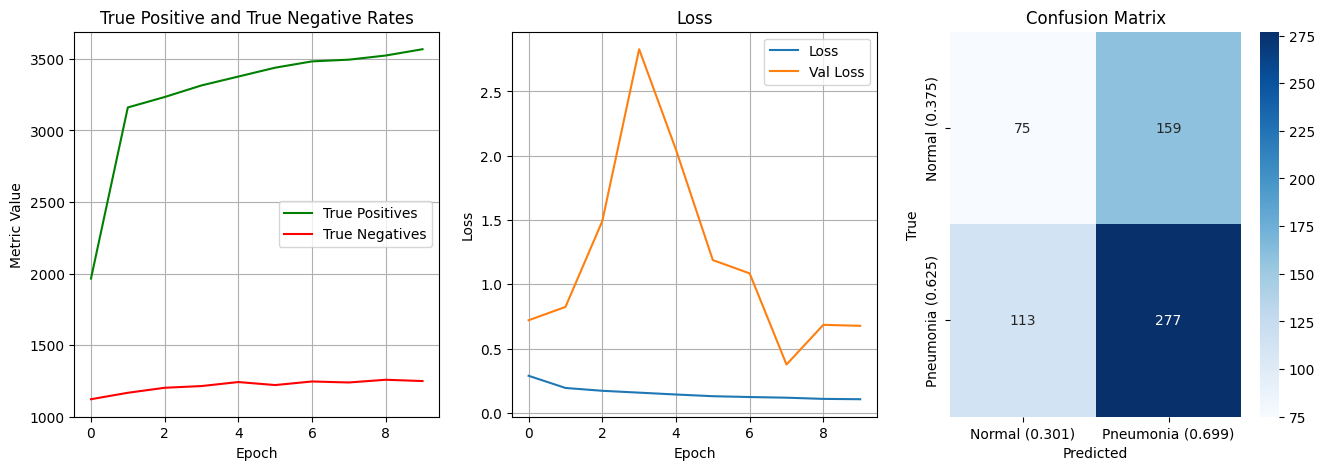

In [21]:
summary_graphics(history, model_2)

In [22]:
notebook_end_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_end_time} (duration: {notebook_end_time - notebook_start_time})")

Notebook last run (end-to-end): 2025-04-26 22:57:44.781189 (duration: 8:35:49.273300)
